In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  #hide GPUs from tf so it doesnt try to use them and get memory errors
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras_tuner import RandomSearch
from mpl_toolkits.mplot3d import Axes3D 

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LeakyReLU

from parameters import *

In [2]:
def build_hypermodel(hp):
        # Hyperparameters to tune
        neurons_per_layer = [hp.Int(f'neurons_{i}', min_value=100, max_value=5000, step=100) for i in range(3)]
        #dont look at any dropout for now, I think this model likes no dropout, because we have lots of data and a complex model. 
        #even with 0.1 dropout the validation loss is always lower than test loss by some delta across all epochs
        #dropout_rate = hp.Float('dropout_rate', TRAIN_DROPOUT_RATE, 0.5, step=0.1)
        
        # Create Model in the same way that we do by hand
        model = Sequential()
        model.add(Input(shape=(602,), name='input1'))
    
        for i, n in enumerate(neurons_per_layer):
            model.add(Dense(n, name=f'fc{i}', kernel_initializer='lecun_uniform', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
            model.add(LeakyReLU(alpha=0.01, name=f'leaky_relu{i}'))
            #model.add(Dropout(rate=dropout_rate, name=f'dropout{i}'))
    
        model.add(Dense(10, name='output', kernel_initializer='lecun_uniform'))
    
        # Learning rate configuration
        lr_initial = hp.Float('learning_rate', 1e-6, 5e-3, sampling='LOG', default=0.0001)
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=lr_initial,
            decay_steps=LR_DECAY_STEPS,
            decay_rate=LR_DECAY_RATE,
            staircase=LR_STAIRCASE
        )
    
        model.compile(optimizer=tf.optimizers.Adam(learning_rate=lr_schedule), 
                      loss='mean_squared_error',
                      metrics=['mean_squared_error'])
        return model

In [3]:
# Load the tuner results
tuner = RandomSearch(
    build_hypermodel,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=1,
    directory='keras/hyper_tuning_one_hot_encoding',
    project_name='mlp_tuning_one_hot_encoding'
)

tuner.reload()

Reloading Tuner from keras/hyper_tuning_one_hot_encoding/mlp_tuning_one_hot_encoding/tuner0.json


In [4]:
# Ensure all val_loss values are numeric
def get_numeric_val_loss(metric):
    """Extracts the minimum val_loss as a float from MetricObservation."""
    if metric and hasattr(metric, "get_history"):
        # Extract val_loss from history and get the minimum value
        return float(min(metric.get_history('val_loss')))
    return None

In [5]:
# Extract the trials
all_trials = tuner.oracle.trials

results = []
for trial_id, trial in all_trials.items():
    trial_data = trial.hyperparameters.values
    # Check if 'val_loss' is in the tracked metrics
    if 'val_loss' in trial.metrics.metrics:
        # Extract the best val_loss from MetricObservation objects
        val_loss_history = trial.metrics.get_history('val_loss')
        trial_data['val_loss'] = min([obs.value[0] for obs in val_loss_history if obs.value])
    else:
        trial_data['val_loss'] = None  # Mark it as None if not available
    
    # Calculate total number of neurons across layers
    trial_data['total_params'] = sum(trial_data.get(f'neurons_{i}', 0) for i in range(3))
    trial_data['trial_id'] = trial_id
    results.append(trial_data)

# Convert results to DataFrame
df = pd.DataFrame(results)

# Filter out any trials that didn't track 'val_loss'
df = df.dropna(subset=['val_loss'])

print(df.head())

   neurons_0  neurons_1  neurons_2  neurons_3  dropout_rate  learning_rate  \
0       1200       4100        400        800           0.4       0.004157   
1       3200       4700       1200       2200           0.4       0.000109   
2       2800       4700        800       4600           0.4       0.003825   
3       3100       4600       2800       3900           0.4       0.000491   
4        400       3200       1100       3300           0.4       0.000501   

   val_loss  total_params trial_id  
0  0.049026          5700      032  
1  2.350284          9100      166  
2  1.464490          8300      034  
3  0.630937         10500      160  
4  0.122407          4700      029  


float64


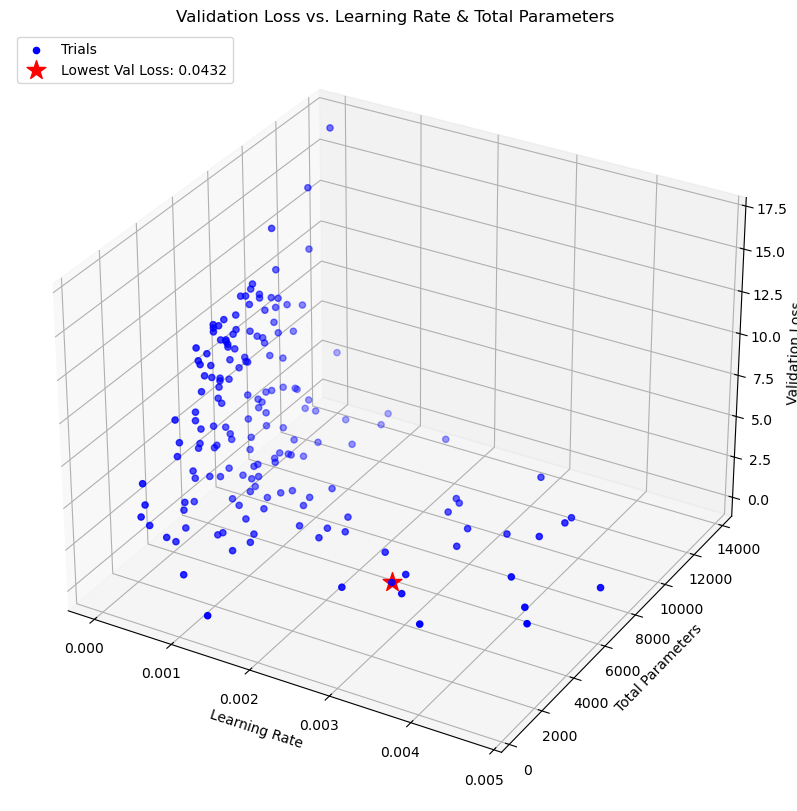

/tmp/ipykernel_1015355/283045375.py:65: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


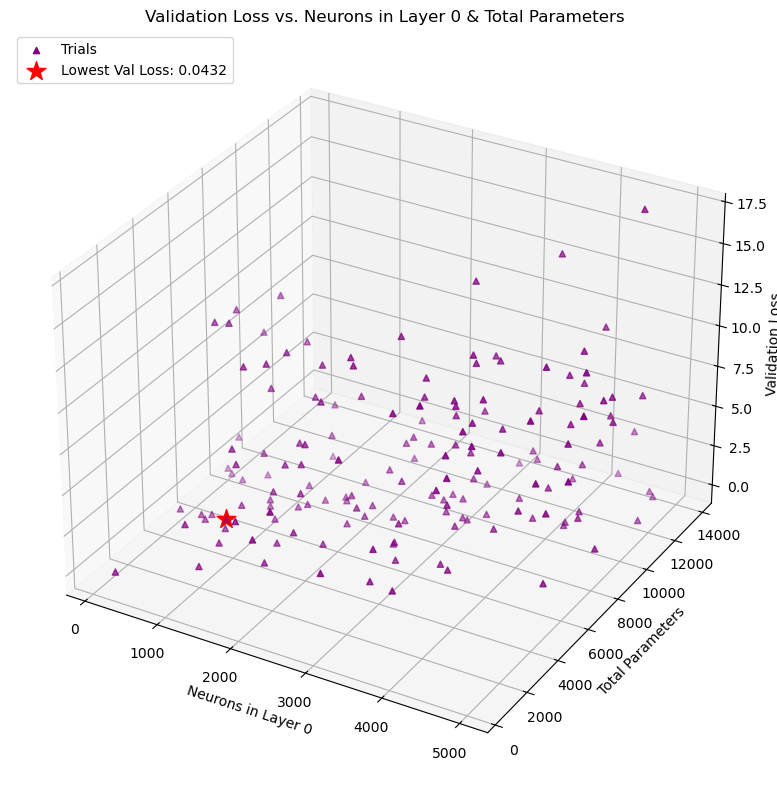

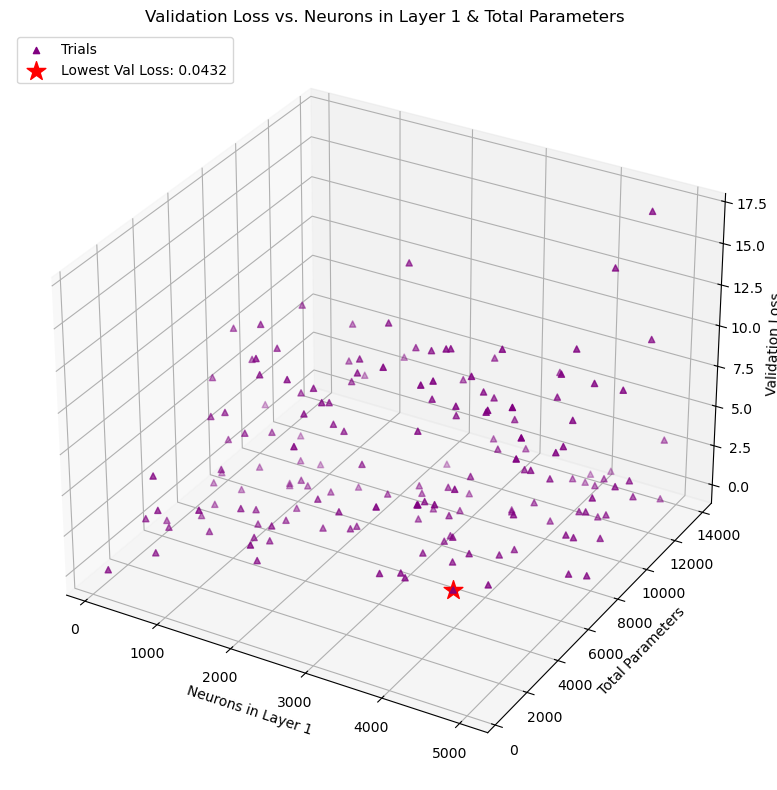

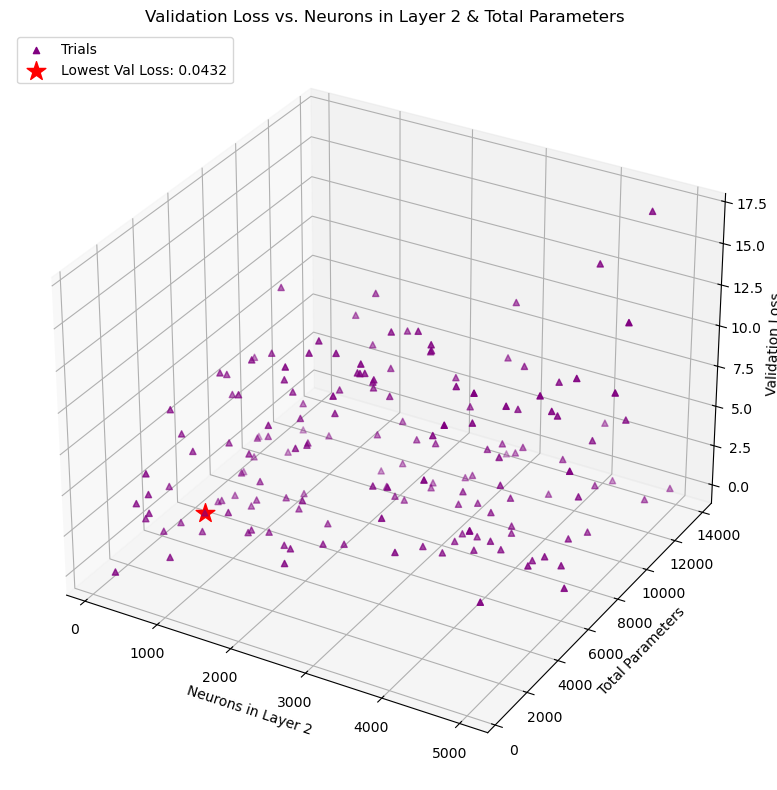

In [6]:
os.makedirs('plots', exist_ok=True)
os.makedirs('plots/hypertuner_search_metrics', exist_ok=True)

# Confirm all values in 'val_loss' are numeric
print(df['val_loss'].dtype)  # Should print float64 or a numeric type

filtered_df = df[df['val_loss'].notna()].copy()

# Find the minimum val_loss and its index
min_val_loss_index = df['val_loss'].idxmin()
min_val_loss_point = df.loc[min_val_loss_index]  # Extract the row as a Series
min_loss = round(filtered_df.loc[filtered_df['val_loss'].idxmin()]['val_loss'], 4)

# Plotting validation loss vs learning rate and total parameters in 3D
fig = plt.figure(figsize=(10, 8), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')

# General scatter plot
scatter = ax.scatter(df['learning_rate'], df['total_params'], df['val_loss'], c='blue', marker='o', label='Trials')

# Highlight the lowest val_loss point
ax.scatter(
    min_val_loss_point['learning_rate'], 
    min_val_loss_point['total_params'], 
    min_val_loss_point['val_loss'], 
    c='red', marker='*', s=200, label=f'Lowest Val Loss: {min_loss}'
)

# Set labels and title
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Total Parameters')
ax.set_zlabel('Validation Loss')
ax.set_title('Validation Loss vs. Learning Rate & Total Parameters')

# Add legend
ax.legend(loc='upper left')

plt.savefig('plots/hypertuner_search_metrics/3D_Val_Loss_vs_Learning_Rate_and_Total_Params_with_Lowest.png')
plt.show()

# Plot validation loss vs neurons per layer (Layer 0) in 3D with special marker
for i in range(3):
    fig = plt.figure(figsize=(10, 8), constrained_layout=True)
    ax = fig.add_subplot(111, projection='3d')
    
    # General scatter plot
    ax.scatter(df[f'neurons_{i}'], df['total_params'], df['val_loss'], c='purple', marker='^', label='Trials')
    
    # Highlight the lowest val_loss point
    ax.scatter(
        min_val_loss_point[f'neurons_{i}'],
        min_val_loss_point['total_params'],
        min_val_loss_point['val_loss'],
        c='red', marker='*', s=200, label=f'Lowest Val Loss: {min_loss}'
    )
    
    # Set labels and title
    ax.set_xlabel(f'Neurons in Layer {i}')
    ax.set_ylabel('Total Parameters')
    ax.set_zlabel('Validation Loss')
    ax.set_title(f'Validation Loss vs. Neurons in Layer {i} & Total Parameters')
    
    # Add legend
    ax.legend(loc='upper left')
    plt.tight_layout()
    
    plt.savefig(f'plots/hypertuner_search_metrics/3D_Val_Loss_vs_Neurons_Layer_{i+1}_and_Total_Params_with_Lowest.png')
    plt.show()

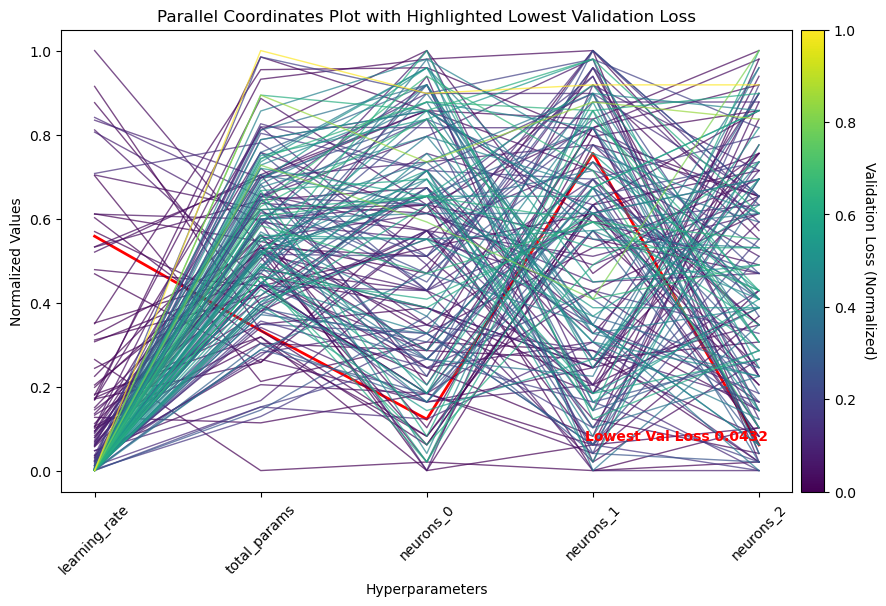

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import matplotlib.colors as mcolors

# Drop unnecessary columns
columns_to_include = ['learning_rate', 'total_params', 'neurons_0', 'neurons_1', 'neurons_2', 'val_loss']
filtered_df = df[columns_to_include]

# Normalize the data for better visualization
norm_df = filtered_df.copy()
norm_df[columns_to_include] = filtered_df[columns_to_include].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Normalize val_loss for color mapping
norm_df['val_loss_normalized'] = (filtered_df['val_loss'] - filtered_df['val_loss'].min()) / (filtered_df['val_loss'].max() - filtered_df['val_loss'].min())

# Sort by val_loss (optional for better visualization order)
norm_df = norm_df.sort_values(by='val_loss').reset_index(drop=True)  # Reset index to avoid misalignment

# Generate colors based on val_loss
cmap = plt.cm.viridis  # Choose a colormap
norm = mcolors.Normalize(vmin=norm_df['val_loss_normalized'].min(), vmax=norm_df['val_loss_normalized'].max())
colors = [cmap(norm(val)) for val in norm_df['val_loss_normalized']]

# Find the index of the row with the lowest val_loss
min_val_loss_index = norm_df['val_loss'].idxmin()

min_loss = round(filtered_df.loc[filtered_df['val_loss'].idxmin()]['val_loss'], 4)

# Plot parallel coordinates with colormap
fig, ax = plt.subplots(figsize=(12, 6))
for idx, row in norm_df.iterrows():
    line = ax.plot(
        columns_to_include[:-1],  # Hyperparameters and val_loss columns
        row[columns_to_include[:-1]],
        color='red' if idx == min_val_loss_index else colors[idx],  # Highlight the minimum val_loss in red
        alpha=1.0 if idx == min_val_loss_index else 0.7,  # Make the highlighted line more prominent
        linewidth=2.0 if idx == min_val_loss_index else 1.0  # Make the highlighted line thicker
    )
    # Add label for the minimum val_loss line
    if idx == min_val_loss_index:
        ax.text(
            len(columns_to_include[:-1]) - 1.5,  # Position near the last axis (val_loss column)
            row[columns_to_include[:-1]].iloc[-1] + 0.01,  # Shift the label slightly above the line
            f'Lowest Val Loss {min_loss}', 
            color='red', 
            fontsize=10, 
            fontweight='bold', 
            ha='center'
        )

# Adjust plot margins to ensure the label is visible
plt.subplots_adjust(right=0.85)

# Add a dummy ScalarMappable for the colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Dummy array for the colorbar
cbar = fig.colorbar(sm, ax=ax, pad=0.01)  # Explicitly pass the Axes to the colorbar
cbar.set_label('Validation Loss (Normalized)', rotation=270, labelpad=15)

# Plot settings
ax.set_title('Parallel Coordinates Plot with Highlighted Lowest Validation Loss')
ax.set_xlabel('Hyperparameters')
ax.set_ylabel('Normalized Values')
ax.set_xticks(range(len(columns_to_include[:-1])))
ax.set_xticklabels(columns_to_include[:-1], rotation=45)  # Rotate x-axis labels for better readability
plt.savefig(f'plots/hypertuner_search_metrics/parallel_coordinates.png')
plt.show()


In [8]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Option 1: print everything as a dict
print(best_hps.values)

# Option 2: print each one nicely
print("neurons_0:", best_hps.get('neurons_0'))
print("neurons_1:", best_hps.get('neurons_1'))
print("neurons_2:", best_hps.get('neurons_2'))
print("neurons_3:", best_hps.get('neurons_3'))
print("dropout_rate:", best_hps.get('dropout_rate'))
print("learning_rate:", best_hps.get('learning_rate'))

{'neurons_0': 700, 'neurons_1': 3800, 'neurons_2': 400, 'neurons_3': 1800, 'dropout_rate': 0.4, 'learning_rate': 0.00264849952344695, 'val_loss': 0.043171659111976624, 'total_params': 4900, 'trial_id': '031'}
neurons_0: 700
neurons_1: 3800
neurons_2: 400
neurons_3: 1800
dropout_rate: 0.4
learning_rate: 0.00264849952344695
